# Project - 한국어 영화리뷰 감성분석

# 전처리

In [3]:
import urllib.request
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import re

tokenizer = Mecab()
stopwords = ['의','가','이','은', '을','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '겠', '음']

def preprocess_review(sentence):
    sentence = re.sub(r'\([^)]*\)',r'',sentence)
    sentence = re.sub(r'\[[^)]*\]',r'',sentence )
    
    sentence = re.sub(r'["."]{2,}', r" '..' ", sentence)
    sentence = re.sub(r'["?"]{2,}', r" ?? ", sentence)
    sentence = re.sub(r'["!"]{2,}', r" !! ", sentence)
    sentence = re.sub(r'["ㅜ"]{2,}', r" ㅜㅜ ", sentence)
    sentence = re.sub(r'["ㅠ"]{2,}', r" ㅠㅠ ", sentence)
    sentence = re.sub(r'["ㅋ"]{2,}', r" ㅋㅋ ", sentence)
    sentence = re.sub(r'["ㅎ"]{2,}', r" ㅎㅎ ", sentence)
    sentence = re.sub(r'["ㄱ"]{2,}', r" ㄱㄱ ", sentence)
    sentence = re.sub(r'["ㄷ"]{2,}', r" ㄷㄷ ", sentence)
    sentence = re.sub(r'["ㅅ"]{2,}', r" ㅅㅅ ", sentence)
    sentence = re.sub(r'["ㅊ"]{2,}', r" ㅊㅊ ", sentence)
    
    sentence = re.sub(r'["ㅈㄴ"]+', "", sentence)
    sentence = re.sub(r'["ㅅㅂ"]+', "", sentence)
    
    sentence = re.sub(r"[^ㄱ-ㅎ|ㅏ-ㅣ|가-힣.?!,' ]+", "", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) # 3

    return sentence

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].apply(lambda x: preprocess_review(str(x)))
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].apply(lambda x: preprocess_review(str(x)))
    test_data = test_data.dropna(how = 'any') 
    
    
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() # 왜???
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

불용어를 추가했고, 연속된 .을 예외처리하고, ㅋㅋㅋㅋㅋㅋㅋㅋ-> ㅋㅋ, ㅠㅠㅠㅠㅠㅠ->ㅠㅠ 등의 변환을 진행했습니다

## Utils

In [62]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 13, 1900, 6803]


In [63]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

<UNUSED> the and


In [64]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] #가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 13, 235, 5396], [1, 13, 1900, 6803], [1, 150, 13, 235, 654]]


In [65]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] #가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['<UNUSED> the and', '<UNUSED> a of', 'to <UNUSED> the is']


In [4]:
preprocess_review('아.......      머냐 정말')

"아 '..' 머냐 정말"

In [5]:
tokenizer.morphs(preprocess_review('아 .......'))

['아', "'..'"]

In [6]:
data_dir = '~/aiffel/sentiment_classification/data'
train_path = os.path.join(data_dir, 'ratings_train.txt')
test_path = os.path.join(data_dir, 'ratings_test.txt')

train_data = pd.read_csv(train_path, sep = "\t", engine='python')
test_data = pd.read_csv(test_path, sep = "\t", engine='python')
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [13]:
X_train, y_train, X_test, y_test, word_dict = load_data(train_data, test_data)

In [5]:
word_dict

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 "'..'": 5,
 '영화': 6,
 '다': 7,
 '고': 8,
 '하': 9,
 '보': 10,
 '!': 11,
 ',': 12,
 '게': 13,
 '지': 14,
 '있': 15,
 '?': 16,
 '없': 17,
 '좋': 18,
 '나': 19,
 '었': 20,
 '만': 21,
 '는데': 22,
 '너무': 23,
 '봤': 24,
 '적': 25,
 '안': 26,
 '정말': 27,
 '로': 28,
 '것': 29,
 '아': 30,
 'ㅋㅋ': 31,
 '네요': 32,
 '재밌': 33,
 '어': 34,
 '같': 35,
 '지만': 36,
 '진짜': 37,
 '했': 38,
 '에서': 39,
 '기': 40,
 '네': 41,
 '점': 42,
 '않': 43,
 '거': 44,
 '았': 45,
 '수': 46,
 '되': 47,
 '면': 48,
 '말': 49,
 '인': 50,
 '연기': 51,
 '주': 52,
 '최고': 53,
 '내': 54,
 '평점': 55,
 '이런': 56,
 '던': 57,
 '어요': 58,
 '할': 59,
 '왜': 60,
 '스토리': 61,
 '해': 62,
 '습니다': 63,
 '드라마': 64,
 '생각': 65,
 '아니': 66,
 '더': 67,
 '듯': 68,
 '그': 69,
 '싶': 70,
 '사람': 71,
 '때': 72,
 '감동': 73,
 '배우': 74,
 '함': 75,
 '본': 76,
 '까지': 77,
 '뭐': 78,
 '만들': 79,
 '알': 80,
 '내용': 81,
 '볼': 82,
 '감독': 83,
 '보다': 84,
 '라': 85,
 '그냥': 86,
 '재미': 87,
 '시간': 88,
 '지루': 89,
 '재미있': 90,
 '중': 91,
 '였': 92,
 '년': 93,
 '잼': 94,
 

In [14]:
index_dict = {index:word for word, index in word_dict.items()}

변환이 제대로 되었는지 8892번으로 확인해 봅니다

In [217]:
X_train[8892]

[141,
 52,
 40,
 133,
 8,
 42,
 353,
 6,
 50,
 68,
 5,
 764,
 10,
 102,
 377,
 14,
 9,
 8,
 76,
 54,
 682,
 5,
 141,
 2512,
 8,
 88,
 5396,
 5,
 81,
 202,
 137]

In [218]:
z = train_data['document'].iloc[8892]
z

"돈주기도 아깝고 점도 아까운 영화인듯 '..' 점점 보면서 무섭겠지 하고 본 내가 잘못 '..' 돈도 날리고 시간도 날림 '..' 내용 결말도 모르겠음"

In [215]:
tokenizer.morphs(z)

['돈',
 '주',
 '기',
 '도',
 '아깝',
 '고',
 '점',
 '도',
 '아까운',
 '영화',
 '인',
 '듯',
 "'..'",
 '점점',
 '보',
 '면서',
 '무섭',
 '겠',
 '지',
 '하',
 '고',
 '본',
 '내',
 '가',
 '잘못',
 "'..'",
 '돈',
 '도',
 '날리',
 '고',
 '시간',
 '도',
 '날림',
 "'..'",
 '내용',
 '결말',
 '도',
 '모르',
 '겠',
 '음']

In [220]:
get_decoded_sentence(X_train[8892], index_dict)

"주 기 아깝 고 점 아까운 영화 인 듯 '..' 점점 보 면서 무섭 지 하 고 본 내 잘못 '..' 돈 날리 고 시간 날림 '..' 내용 결말 모르"

In [19]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2.2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2.2* np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.2f}%가 maxlen 설정값 이내에 포함됩니다. '\
      .format(100 * np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  14.72597150623781
문장길이 최대 :  90
문장길이 표준편차 :  12.03288677655105
pad_sequences maxlen :  41
전체 문장의 94.38%가 maxlen 설정값 이내에 포함됩니다. 


In [17]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_dict["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_dict["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000,)


In [18]:
X_train[8892]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  141,
         52,   40,  133,    8,   42,  353,    6,   50,   68,    5,  764,
         10,  102,  377,   14,    9,    8,   76,   54,  682,    5,  141,
       2512,    8,   88, 5396,    5,   81,  202,  137], dtype=int32)

In [225]:
# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116183건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116183, 41)
(116183,)


# Modeling

노드에 있었던 LSTM을 그대로 사용합니다

In [229]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)


# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(20))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                22160     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,582,337
Trainable params: 2,582,337
Non-trainable params: 0
_________________________________________________________________


In [230]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=35  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/35
227/227 [==============================] - 10s 38ms/step - loss: 0.5306 - accuracy: 0.7374 - val_loss: 0.3558 - val_accuracy: 0.8429
Epoch 2/35
227/227 [==============================] - 7s 31ms/step - loss: 0.3261 - accuracy: 0.8625 - val_loss: 0.3433 - val_accuracy: 0.8491
Epoch 3/35
227/227 [==============================] - 7s 31ms/step - loss: 0.2927 - accuracy: 0.8765 - val_loss: 0.3427 - val_accuracy: 0.8514
Epoch 4/35
227/227 [==============================] - 7s 31ms/step - loss: 0.2635 - accuracy: 0.8909 - val_loss: 0.3561 - val_accuracy: 0.8506
Epoch 5/35
227/227 [==============================] - 7s 31ms/step - loss: 0.2393 - accuracy: 0.9024 - val_loss: 0.3661 - val_accuracy: 0.8501
Epoch 6/35
227/227 [==============================] - 7s 31ms/step - loss: 0.2154 - accuracy: 0.9138 - val_loss: 0.3807 - val_accuracy: 0.8479
Epoch 7/35
227/227 [==============================] - 7s 31ms/step - loss: 0.1925 - accuracy: 0.9236 - val_loss: 0.4155 - val_accuracy: 0.845

In [231]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 1.1215 - accuracy: 0.8212
[1.1214877367019653, 0.8212498426437378]


# Visualization

In [232]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


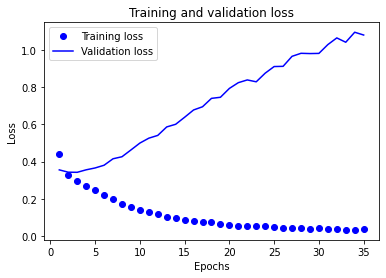

In [233]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

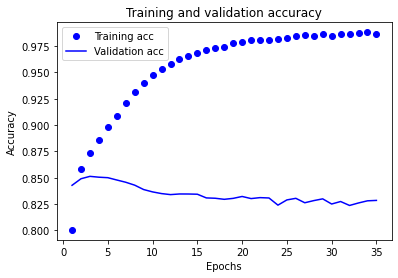

In [234]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Embedding 확인

In [240]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 256)


In [249]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
korword2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/korword2vec.txt'
f = open(korword2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_dict[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [250]:
!pip install python-Levenshtein

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [258]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(korword2vec_file_path, binary=False)
vector = word_vectors['사랑']

In [280]:
word_vectors.similar_by_word("환불")

[('모욕감', 0.8663002848625183),
 ('전범', 0.8649090528488159),
 ('엔드', 0.8649000525474548),
 ('맛없', 0.860942006111145),
 ('기세', 0.8602627515792847),
 ('돌려줘', 0.8555967807769775),
 ('장황', 0.8539468050003052),
 ('두서없', 0.8535993695259094),
 ('구토', 0.8527951836585999),
 ('드러워', 0.8521035313606262)]

In [282]:
word_vectors.similar_by_word("찡해")

[('진진', 0.9001253843307495),
 ('어울려요', 0.897615909576416),
 ('완소', 0.8911107182502747),
 ('아름다워요', 0.887816846370697),
 ('끝장', 0.8808766603469849),
 ('조음', 0.8782219290733337),
 ('습니당', 0.8781096935272217),
 ('버렷', 0.8779062032699585),
 ('아메리칸', 0.8776456117630005),
 ('표한다', 0.876860499382019)]

# Modeling 2

train_val, test_val을 만들어 봅니다.

In [283]:
from sklearn.model_selection import train_test_split

X_train, X_trainval, y_train, y_trainval = train_test_split(
        X_train, y_train, test_size=0.25)
X_test, X_testval, y_test, y_testval = train_test_split(
        X_test, y_test, test_size=0.25)

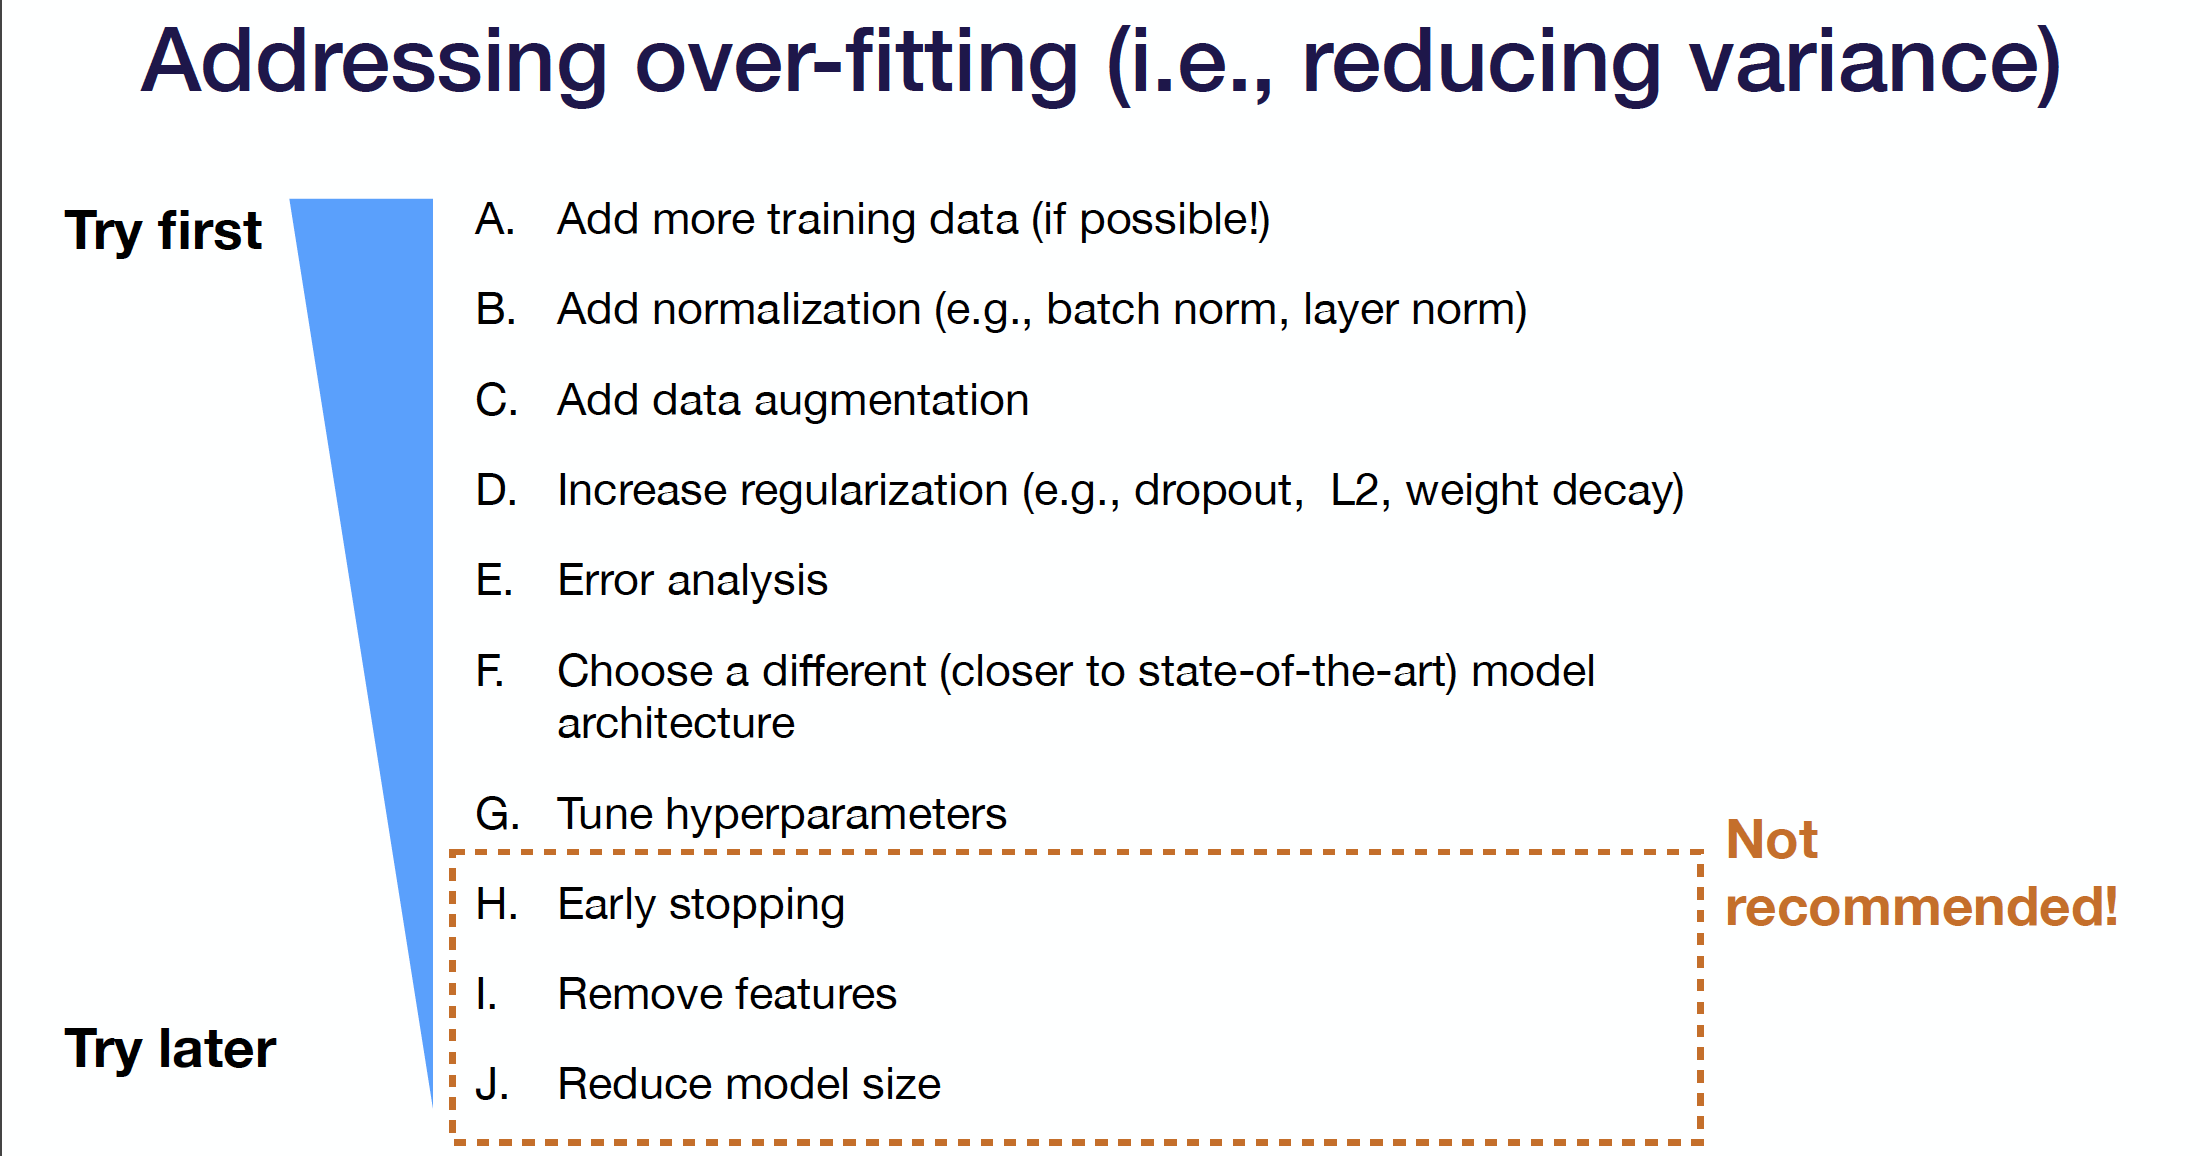

Layer Normalization을 더해 봅니다. reccurrent dropout도 적용 가능합니다

In [26]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [287]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2)
rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)



# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(rnn)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
rnn (RNN)                    (None, 20)                22520     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,582,697
Trainable params: 2,582,697
Non-trainable params: 0
_________________________________________________________________


In [288]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=35  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_trainval, y_trainval),
                    verbose=1)

Epoch 1/35
215/215 [==============================] - 43s 187ms/step - loss: 0.5538 - accuracy: 0.7072 - val_loss: 0.3709 - val_accuracy: 0.8360
Epoch 2/35
215/215 [==============================] - 40s 185ms/step - loss: 0.3184 - accuracy: 0.8679 - val_loss: 0.3487 - val_accuracy: 0.8472
Epoch 3/35
215/215 [==============================] - 39s 183ms/step - loss: 0.2614 - accuracy: 0.8929 - val_loss: 0.3627 - val_accuracy: 0.8484
Epoch 4/35
215/215 [==============================] - 39s 183ms/step - loss: 0.2208 - accuracy: 0.9124 - val_loss: 0.3728 - val_accuracy: 0.8484
Epoch 5/35
215/215 [==============================] - 38s 178ms/step - loss: 0.1872 - accuracy: 0.9277 - val_loss: 0.3973 - val_accuracy: 0.8440
Epoch 6/35
215/215 [==============================] - 38s 177ms/step - loss: 0.1566 - accuracy: 0.9403 - val_loss: 0.4304 - val_accuracy: 0.8441
Epoch 7/35
215/215 [==============================] - 38s 176ms/step - loss: 0.1329 - accuracy: 0.9501 - val_loss: 0.4672 - val_ac

KeyboardInterrupt: 

In [289]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1153/1153 - 19s - loss: 0.8409 - accuracy: 0.8326
[0.8409268856048584, 0.8325648307800293]


In [290]:
results = model.evaluate(X_testval,  y_testval, verbose=2)

print(results)

385/385 - 6s - loss: 0.8160 - accuracy: 0.8377
[0.8159926533699036, 0.8376728892326355]


아직 오버피팅이 남아있습니다. L2 Regularizer를 추가합니다

In [27]:
from keras.regularizers import l2

In [293]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, kernel_regularizer=l2(2e-3), recurrent_regularizer=l2(2e-3))
rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)



# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(rnn)
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
rnn_1 (RNN)                  (None, 20)                22520     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,582,697
Trainable params: 2,582,697
Non-trainable params: 0
_________________________________________________________________


In [294]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_trainval, y_trainval),
                    verbose=1)

Epoch 1/15
215/215 [==============================] - 43s 186ms/step - loss: 0.9100 - accuracy: 0.6854 - val_loss: 0.5695 - val_accuracy: 0.8359
Epoch 2/15
215/215 [==============================] - 40s 184ms/step - loss: 0.5029 - accuracy: 0.8596 - val_loss: 0.4549 - val_accuracy: 0.8453
Epoch 3/15
215/215 [==============================] - 39s 182ms/step - loss: 0.3772 - accuracy: 0.8840 - val_loss: 0.4406 - val_accuracy: 0.8371
Epoch 4/15
215/215 [==============================] - 39s 182ms/step - loss: 0.3205 - accuracy: 0.8978 - val_loss: 0.4087 - val_accuracy: 0.8473
Epoch 5/15
215/215 [==============================] - 38s 179ms/step - loss: 0.2852 - accuracy: 0.9078 - val_loss: 0.4135 - val_accuracy: 0.8448
Epoch 6/15
215/215 [==============================] - 38s 175ms/step - loss: 0.2546 - accuracy: 0.9189 - val_loss: 0.4211 - val_accuracy: 0.8440
Epoch 7/15
215/215 [==============================] - 38s 175ms/step - loss: 0.2311 - accuracy: 0.9287 - val_loss: 0.4234 - val_ac

regularization을 강화합니다

In [295]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))
rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)



# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(rnn)
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03)))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
rnn_2 (RNN)                  (None, 20)                22520     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,582,697
Trainable params: 2,582,697
Non-trainable params: 0
_________________________________________________________________


In [296]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_trainval, y_trainval),
                    verbose=1)

Epoch 1/15
215/215 [==============================] - 43s 185ms/step - loss: 1.9710 - accuracy: 0.7209 - val_loss: 0.6158 - val_accuracy: 0.8336
Epoch 2/15
215/215 [==============================] - 39s 182ms/step - loss: 0.5400 - accuracy: 0.8559 - val_loss: 0.4551 - val_accuracy: 0.8473
Epoch 3/15
215/215 [==============================] - 39s 180ms/step - loss: 0.3890 - accuracy: 0.8807 - val_loss: 0.4179 - val_accuracy: 0.8501
Epoch 4/15
215/215 [==============================] - 38s 177ms/step - loss: 0.3398 - accuracy: 0.8898 - val_loss: 0.3995 - val_accuracy: 0.8510
Epoch 5/15
215/215 [==============================] - 37s 173ms/step - loss: 0.3065 - accuracy: 0.9009 - val_loss: 0.4047 - val_accuracy: 0.8470
Epoch 6/15
215/215 [==============================] - 37s 173ms/step - loss: 0.2833 - accuracy: 0.9095 - val_loss: 0.4066 - val_accuracy: 0.8418
Epoch 7/15
215/215 [==============================] - 39s 183ms/step - loss: 0.2698 - accuracy: 0.9125 - val_loss: 0.4131 - val_ac

In [299]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, dropout=0.3, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))
rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)



# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(rnn)
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03)))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
rnn_3 (RNN)                  (None, 20)                22520     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 168       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,582,697
Trainable params: 2,582,697
Non-trainable params: 0
_________________________________________________________________


In [300]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_trainval, y_trainval),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
215/215 [==============================] - 45s 193ms/step - loss: 2.0599 - accuracy: 0.6610 - val_loss: 0.6504 - val_accuracy: 0.8333
Epoch 2/15
215/215 [==============================] - 41s 190ms/step - loss: 0.5698 - accuracy: 0.8461 - val_loss: 0.4552 - val_accuracy: 0.8457
Epoch 3/15
215/215 [==============================] - 40s 188ms/step - loss: 0.4079 - accuracy: 0.8692 - val_loss: 0.4174 - val_accuracy: 0.8467
Epoch 4/15
215/215 [==============================] - 40s 185ms/step - loss: 0.3525 - accuracy: 0.8827 - val_loss: 0.3995 - val_accuracy: 0.8501
Epoch 5/15
215/215 [==============================] - 39s 183ms/step - loss: 0.3195 - accuracy: 0.8921 - val_loss: 0.4077 - val_accuracy: 0.8483


model size를 키워 봅니다

In [301]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, dropout=0.3, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))
rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)



# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(rnn)
model.add(keras.layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
rnn_4 (RNN)                  (None, 20)                22520     
_________________________________________________________________
dense_12 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 16        
Total params: 2,582,851
Trainable params: 2,582,851
Non-trainable params: 0
_________________________________________________________________


In [303]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='bigger_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_trainval, y_trainval),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
215/215 [==============================] - 44s 192ms/step - loss: 1.9134 - accuracy: 0.6997 - val_loss: 0.6316 - val_accuracy: 0.8351
Epoch 2/15
215/215 [==============================] - 41s 189ms/step - loss: 0.5456 - accuracy: 0.8537 - val_loss: 0.4436 - val_accuracy: 0.8459
Epoch 3/15
215/215 [==============================] - 41s 189ms/step - loss: 0.3897 - accuracy: 0.8733 - val_loss: 0.4119 - val_accuracy: 0.8494
Epoch 4/15
215/215 [==============================] - 40s 187ms/step - loss: 0.3402 - accuracy: 0.8803 - val_loss: 0.3948 - val_accuracy: 0.8502
Epoch 5/15
215/215 [==============================] - 40s 184ms/step - loss: 0.3009 - accuracy: 0.8942 - val_loss: 0.4255 - val_accuracy: 0.8441


In [307]:
model.load_weights('bigger_model.h5')

In [309]:
model.evaluate(X_testval, y_testval)

385/385 [==============================] - 7s 17ms/step - loss: 0.3883 - accuracy: 0.8530


[0.3883100152015686, 0.8529698848724365]

In [310]:
model.evaluate(X_test, y_test)

1153/1153 [==============================] - 20s 17ms/step - loss: 0.4010 - accuracy: 0.8465


[0.4010196328163147, 0.8465335965156555]

## Visualization - bigger model

In [311]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


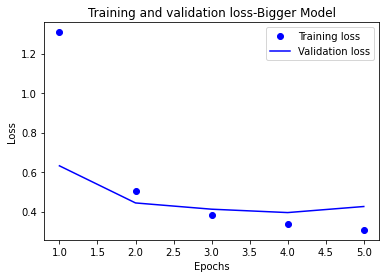

In [312]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss-Bigger Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

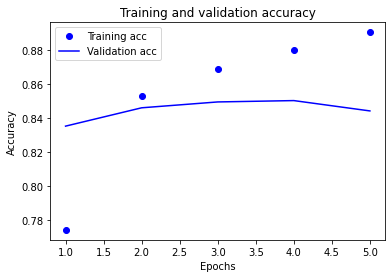

In [313]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Embedding 확인

In [314]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 256)


In [315]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
korword2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/korword2vec.txt'
f = open(korword2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_dict[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [316]:
!pip install python-Levenshtein

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [317]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(korword2vec_file_path, binary=False)
vector = word_vectors['사랑']

In [318]:
word_vectors.similar_by_word("환불")

[('지루', 0.515977144241333),
 ('쓰레기', 0.5052806735038757),
 ('짝퉁', 0.49391382932662964),
 ('건만', 0.48810523748397827),
 ('흐지부지', 0.47872394323349),
 ('안습', 0.47653213143348694),
 ('엉성', 0.47538456320762634),
 ('웹툰', 0.4743560254573822),
 ('류영화', 0.47227564454078674),
 ('고리타분', 0.4617747962474823)]

In [319]:
word_vectors.similar_by_word("찡해")

[('슬퍼요', 0.5959061980247498),
 ('웰메이드', 0.5744625926017761),
 ('올려야', 0.5720795392990112),
 ('못지않', 0.5689052939414978),
 ('최고', 0.5607280731201172),
 ('여운', 0.5598440170288086),
 ('아아아아', 0.5515919327735901),
 ('하모니', 0.5510311126708984),
 ('걸작', 0.548851728439331),
 ('진진', 0.5430724620819092)]

In [320]:
word_vectors.similar_by_word("어이")

[('매년', 0.3825776278972626),
 ('밋밋', 0.34150099754333496),
 ('얄팍', 0.33527055382728577),
 ('라디오스타', 0.33234933018684387),
 ('몰아넣', 0.33099591732025146),
 ('남동생', 0.32500025629997253),
 ('민망', 0.32445603609085083),
 ('건지', 0.3181726932525635),
 ('원주', 0.31662148237228394),
 ('거창', 0.3122236430644989)]

In [321]:
word_vectors.similar_by_word("신파")

[('깬다', 0.4877643883228302),
 ('읎', 0.4663582146167755),
 ('아까웠', 0.4635729491710663),
 ('안드로메다', 0.45204997062683105),
 ('짝퉁', 0.435527503490448),
 ('졸작', 0.43470633029937744),
 ('쯔쯔', 0.4332006573677063),
 ('아녀', 0.43075042963027954),
 ('건만', 0.4292519688606262),
 ('별루', 0.4275715947151184)]

In [322]:
word_vectors.similar_by_word("통쾌")

[('최고', 0.5949416160583496),
 ('유쾌', 0.569293200969696),
 ('이제서야', 0.5685508847236633),
 ('금방', 0.5677363872528076),
 ('묵직', 0.5650110244750977),
 ('므', 0.5618212223052979),
 ('즐겼', 0.5569055080413818),
 ('굿', 0.5556231141090393),
 ('싯', 0.5548487901687622),
 ('이만큼', 0.5544086694717407)]

In [329]:
word_vectors.similar_by_word("코끝")

[('기타노', 0.5575615763664246),
 ('올려야', 0.5389668345451355),
 ('쨩', 0.5311573147773743),
 ('값진', 0.5300745964050293),
 ('고인', 0.5268189907073975),
 ('정윤희', 0.5216978192329407),
 ('따뜻', 0.5155426859855652),
 ('명불허전', 0.5151960253715515),
 ('미남', 0.5151045918464661),
 ('기막힌', 0.5141910910606384)]

In [337]:
word_vectors.similar_by_word("여운")

[('흠잡', 0.7358710765838623),
 ('수작', 0.6813348531723022),
 ('하모니', 0.6698699593544006),
 ('탄탄', 0.6687657237052917),
 ('진진', 0.6683276891708374),
 ('최고', 0.6617761850357056),
 ('소장', 0.6538336277008057),
 ('못지않', 0.6504384279251099),
 ('웰메이드', 0.6493259072303772),
 ('쨩', 0.6486030220985413)]

임베딩이 잘 되었습니다

# 한국어 word2vec 적용하기

In [1]:
pip install --upgrade gensim==3.8.3

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import gensim
from gensim.models import keyedvectors

kobin_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
gsm = gensim.models.Word2Vec.load(kobin_path)

In [20]:
gsm.similar_by_word("어이")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('손색', 0.5056970119476318),
 ('원어', 0.4926360249519348),
 ('가차', 0.4736453592777252),
 ('턱잎', 0.46982482075691223),
 ('틀림', 0.45877450704574585),
 ('어의', 0.45466524362564087),
 ('어는', 0.44959020614624023),
 ('어판', 0.43901583552360535),
 ('모국어', 0.43108823895454407),
 ('스페인어', 0.42124444246292114)]

In [21]:
gsm.similar_by_word("여운")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('태의', 0.6230935454368591),
 ('홍인', 0.5903868675231934),
 ('박승', 0.5838495492935181),
 ('박시', 0.5824265480041504),
 ('이원', 0.5818819403648376),
 ('정인', 0.5793002247810364),
 ('서재', 0.5730061531066895),
 ('이태', 0.5705349445343018),
 ('이병', 0.5646387338638306),
 ('정재', 0.5624488592147827)]

In [22]:
gsm.similar_by_word("환불")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('할인', 0.7105085849761963),
 ('결제', 0.6978827714920044),
 ('수수료', 0.6828742623329163),
 ('대출', 0.6768600344657898),
 ('현금', 0.6736488342285156),
 ('보증금', 0.6713371872901917),
 ('예약', 0.6616930961608887),
 ('인출', 0.6482876539230347),
 ('환급', 0.6442877054214478),
 ('잔액', 0.6221246123313904)]

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 word2vec이므로 200이다

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_dict[i] in gsm:
        embedding_matrix[i] = gsm[index_dict[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [24]:
gsm["사랑"].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(200,)

In [44]:
from tensorflow.keras.initializers import Constant
from keras.regularizers import l2


vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, dropout=0.15, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))
rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)


# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(rnn)
model.add(keras.layers.Dense(30, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
rnn_3 (RNN)                  (None, 20)                18040     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 2,018,701
Trainable params: 2,018,701
Non-trainable params: 0
_________________________________________________________________


In [36]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                         value=word_dict["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_dict["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146183, 41)


In [37]:
from sklearn.model_selection import train_test_split

X_train_partial, X_val, y_train_partial, y_val = train_test_split(
        X_train, y_train, test_size=0.25)

In [38]:
len(X_train_partial)+len(X_val)

146183

In [45]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='kobin_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
215/215 [==============================] - 43s 186ms/step - loss: 1.8869 - accuracy: 0.6093 - val_loss: 0.6667 - val_accuracy: 0.7671
Epoch 2/15
215/215 [==============================] - 39s 181ms/step - loss: 0.5793 - accuracy: 0.7995 - val_loss: 0.4627 - val_accuracy: 0.8281
Epoch 3/15
215/215 [==============================] - 39s 180ms/step - loss: 0.4443 - accuracy: 0.8356 - val_loss: 0.4165 - val_accuracy: 0.8415
Epoch 4/15
215/215 [==============================] - 38s 178ms/step - loss: 0.4016 - accuracy: 0.8487 - val_loss: 0.4023 - val_accuracy: 0.8467
Epoch 5/15
215/215 [==============================] - 38s 176ms/step - loss: 0.3784 - accuracy: 0.8567 - val_loss: 0.3961 - val_accuracy: 0.8435
Epoch 6/15
215/215 [==============================] - 37s 174ms/step - loss: 0.3620 - accuracy: 0.8633 - val_loss: 0.3871 - val_accuracy: 0.8501
Epoch 7/15
215/215 [==============================] - 37s 171ms/step - loss: 0.3477 - accuracy: 0.8682 - val_loss: 0.3841 - val_ac

In [46]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 24s - loss: 0.3795 - accuracy: 0.8511
[0.37951526045799255, 0.8511331081390381]


#  85% 이상의 정확도를 확보했습니다

## Embedding 확인하기

In [47]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
realword2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/realword2vec.txt'
f = open(realword2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_dict[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [48]:
!pip install python-Levenshtein

     |████████████████████████████████| 50 kB 2.3 MB/s eta 0:00:011
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=171592 sha256=f4c75c5001c1b781964a7a0b32073f836ef1587c44be6560e08ec8f679880422
  Stored in directory: /aiffel/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(realword2vec_file_path, binary=False)
vector = word_vectors['사랑']

In [51]:
word_vectors.similar_by_word("환불")

[('할인', 0.7253379821777344),
 ('결제', 0.6695911884307861),
 ('구매', 0.5384684801101685),
 ('구입', 0.5036134123802185),
 ('가격', 0.49023178219795227),
 ('처분', 0.489038348197937),
 ('인증', 0.48107144236564636),
 ('수입', 0.46973562240600586),
 ('무료', 0.4667297601699829),
 ('티켓', 0.4666823148727417)]

In [52]:
word_vectors.similar_by_word("찡해")

[('짜린', 0.7983392477035522),
 ('김동욱', 0.7917121052742004),
 ('한석규', 0.7882754802703857),
 ('묵직', 0.7869950532913208),
 ('좋아한다면', 0.7859714031219482),
 ('할께요', 0.7853449583053589),
 ('아름다우', 0.7846046090126038),
 ('섞인', 0.7841967344284058),
 ('집니다', 0.7836501002311707),
 ('여진구', 0.7834502458572388)]

In [53]:
word_vectors.similar_by_word("어이")

[('어의', 0.4406505823135376),
 ('손색', 0.4342666268348694),
 ('중국어', 0.41986754536628723),
 ('발음', 0.3810339570045471),
 ('영어', 0.37704673409461975),
 ('사투리', 0.35119032859802246),
 ('왈', 0.3506443202495575),
 ('어라', 0.3475007712841034),
 ('툭', 0.3412487208843231),
 ('딱히', 0.34122905135154724)]

In [54]:
word_vectors.similar_by_word("신파")

[('좌파', 0.49955302476882935),
 ('우익', 0.4885996878147125),
 ('극우', 0.46810561418533325),
 ('중도', 0.44232016801834106),
 ('진보', 0.4321260452270508),
 ('반공', 0.40664681792259216),
 ('애국', 0.4020945727825165),
 ('신파극', 0.3947174549102783),
 ('어용', 0.39347532391548157),
 ('오우', 0.39002251625061035)]

In [55]:
word_vectors.similar_by_word("통쾌")

[('민영화', 0.8047947883605957),
 ('주르륵', 0.8044050335884094),
 ('일어날', 0.8040308356285095),
 ('흐뭇', 0.8029019832611084),
 ('명연기', 0.7966757416725159),
 ('손색없', 0.7961273789405823),
 ('황홀', 0.7961071729660034),
 ('컨', 0.7958583235740662),
 ('바야', 0.7958544492721558),
 ('셔도', 0.7954989671707153)]

In [56]:
word_vectors.similar_by_word("코끝")

[('아자니', 0.823017954826355),
 ('셜록', 0.8222357034683228),
 ('지으', 0.8075815439224243),
 ('고마워', 0.806937038898468),
 ('왕가위', 0.8055189847946167),
 ('불패', 0.8042044639587402),
 ('기다렸', 0.8037781119346619),
 ('카메론', 0.8034160137176514),
 ('퍼', 0.802844762802124),
 ('김재원', 0.8020819425582886)]

In [57]:
word_vectors.similar_by_word("여운")

[('이만', 0.4999743103981018),
 ('미생', 0.49708008766174316),
 ('용재', 0.4830641448497772),
 ('상우', 0.4733186364173889),
 ('백미', 0.46113118529319763),
 ('이시영', 0.45484018325805664),
 ('이정', 0.44887205958366394),
 ('울림', 0.44680169224739075),
 ('재희', 0.44463446736335754),
 ('고인', 0.44230228662490845)]

정확도는 비슷하지만, 꽤나 다른 임베딩이 되어있는 것을 확인했습니다

# 문장 예측해보기

In [7]:
from tensorflow import keras
import tensorflow_addons as tfa
from keras.regularizers import l2

def encode_sentence(sentence_list):
    X=[]
    for sentence in sentence_list:
        sentence = preprocess_review(sentence)  # 전처리
        temp_X = tokenizer.morphs(sentence)   # 형태소로 분리
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X.append(temp_X)  # 모으기

    encoded_sentences = list(map(wordlist_to_indexlist, X))  # 정수로 인코딩
    return encoded_sentences


def wordlist_to_indexlist(wordlist):
        return [word_dict[word] if word in word_dict else word_dict['<UNK>'] for word in wordlist]

In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, dropout=0.3, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))
rnn = keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)



# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(rnn)
model.add(keras.layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
rnn (RNN)                    (None, 20)                22520     
_________________________________________________________________
dense (Dense)                (None, 15)                315       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 2,582,851
Trainable params: 2,582,851
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.load_weights('bigger_model.h5')

In [22]:
loaded_model = model

In [23]:
def predict_sentences(sentence_list):
    encoded_list = encode_sentence(sentence_list)
    padded_list = keras.preprocessing.sequence.pad_sequences(encoded_list,
                                                        value=word_dict["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)
    score_list = loaded_model.predict(padded_list)
    for sentence, score in zip(sentence_list, score_list):
        if(score > 0.5):
            print(f"문장: {sentence}\n {float(score) * 100:.2f}% 확률로 긍정 리뷰입니다.\n")
        else:
            print(f"문장: {sentence}\n {(1 - float(score)) * 100:.2f}% 확률로 부정 리뷰입니다.\n")

In [25]:
predict_sentences(['이 영화 노잼임', '인생에서 이걸 왜 이제야 만났는지 후회가 됩니다', '가족끼리 말고 연인끼리 보러 오기엔 좋은 영화'])

문장: 이 영화 노잼임
 96.60% 확률로 부정 리뷰입니다.

문장: 인생에서 이걸 왜 이제야 만났는지 후회가 됩니다
 90.43% 확률로 긍정 리뷰입니다.

문장: 가족끼리 말고 연인끼리 보러 오기엔 좋은 영화
 96.49% 확률로 긍정 리뷰입니다.



In [26]:
predict_sentences(['킬링타임용 영화', '다음에 다시 볼 예정', '배우들 연기력만 믿고 만든 영화'])

문장: 킬링타임용 영화
 76.89% 확률로 부정 리뷰입니다.

문장: 다음에 다시 볼 예정
 97.17% 확률로 긍정 리뷰입니다.

문장: 배우들 연기력만 믿고 만든 영화
 61.14% 확률로 긍정 리뷰입니다.



In [27]:
predict_sentences(['감동 여운 결말', '정말 짜증나서 도중에 나오고 싶었음'])

문장: 감동 여운 결말
 97.61% 확률로 긍정 리뷰입니다.

문장: 정말 짜증나서 도중에 나오고 싶었음
 96.83% 확률로 부정 리뷰입니다.



In [32]:
predict_sentences(['더 이상의 마음울림은 없다', '내가 무엇을 본 것인지 기억이 안나', ' 주인공이 멋이 읎서!!'])

문장: 더 이상의 마음울림은 없다
 81.34% 확률로 긍정 리뷰입니다.

문장: 내가 무엇을 본 것인지 기억이 안나
 69.38% 확률로 부정 리뷰입니다.

문장:  주인공이 멋이 읎서!!
 73.82% 확률로 부정 리뷰입니다.



# 회고

1. 여러 단어로 임베딩만 확인했을때는, 이게 잘 된 것이 맞나라는 생각이 듦에도 85% 이상의 성능을 내는 것을 보며 pretrained 임베딩의 위력을 느꼈습니다. 영화 도메인에 한정해서는 한국어 word2vec을 사용하지 않은 모델이 더욱 문맥을 잘 읽는다는 느낌을 받았습니다.

2. 주어진 데이터셋에 라벨이 제대로 붙어있지 않고(재밓었다 -> 0), 모델의 정확도도 실전에서 배포하기엔 매우 부족하지만, 자연어 처리의 첫 걸음마를 뗀 것 같은 생각이 듭니다